In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, LayerNormalization, MultiHeadAttention, Embedding, concatenate, MaxPooling2D, GlobalAveragePooling2D, Multiply
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pyedflib
import mne
import pandas as pd
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

In [2]:
subject_info = pd.read_csv('dataset/subject-info.csv')

In [3]:
def load_edf(file_path):
    f = pyedflib.EdfReader(file_path)
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    f._close()
    return sigbufs, signal_labels

In [4]:
data = {}
for _, row in subject_info.iterrows():
    subject_id = row['Subject']
    group = row['Count quality']
    rest_file = f"dataset/{subject_id}_1.edf"  
    task_file = f"dataset/{subject_id}_2.edf"
    rest_data, rest_labels = load_edf(rest_file)
    task_data, task_labels = load_edf(task_file)
    data[subject_id] = {
        'group': group,
        'rest': rest_data,
        'task': task_data,
        'labels': rest_labels
    }

In [5]:
for subject_id, info in data.items():
    print(f"Subject ID: {subject_id}, Group: {info['group']}, Rest shape: {info['rest'].shape}, Task shape: {info['task'].shape}")

Subject ID: Subject00, Group: 0, Rest shape: (21, 91000), Task shape: (21, 31000)
Subject ID: Subject01, Group: 1, Rest shape: (21, 91000), Task shape: (21, 31000)
Subject ID: Subject02, Group: 1, Rest shape: (21, 91000), Task shape: (21, 31000)
Subject ID: Subject03, Group: 1, Rest shape: (21, 91000), Task shape: (21, 31000)
Subject ID: Subject04, Group: 0, Rest shape: (21, 85000), Task shape: (21, 31000)
Subject ID: Subject05, Group: 1, Rest shape: (21, 91000), Task shape: (21, 31000)
Subject ID: Subject06, Group: 0, Rest shape: (21, 91000), Task shape: (21, 31000)
Subject ID: Subject07, Group: 1, Rest shape: (21, 91000), Task shape: (21, 31000)
Subject ID: Subject08, Group: 1, Rest shape: (21, 91000), Task shape: (21, 31000)
Subject ID: Subject09, Group: 0, Rest shape: (21, 91000), Task shape: (21, 31000)
Subject ID: Subject10, Group: 0, Rest shape: (21, 94000), Task shape: (21, 31000)
Subject ID: Subject11, Group: 1, Rest shape: (21, 91000), Task shape: (21, 31000)
Subject ID: Subj

In [6]:
frequency_bands = {
    'Delta': (1, 4),
    'Theta': (4, 8),
    'Alpha': (8, 12),
    'Beta': (12, 30),
    'Gamma': (30, 100)
}

In [7]:
def calculate_psd(data, sfreq, fmin, fmax):
    psd, freqs = mne.time_frequency.psd_array_welch(data, sfreq=sfreq, fmin=fmin, fmax=fmax, n_fft=2048)
    return psd, freqs

In [8]:
sfreq = 250
subject_id = list(data.keys())[0]
rest_data = data[subject_id]['rest']
task_data = data[subject_id]['task']

In [9]:
psd_rest = {}
psd_task = {}

In [10]:
for band, (fmin, fmax) in frequency_bands.items():
    psd_rest[band], _ = calculate_psd(rest_data, sfreq, fmin, fmax)
    psd_task[band], _ = calculate_psd(task_data, sfreq, fmin, fmax)

Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)


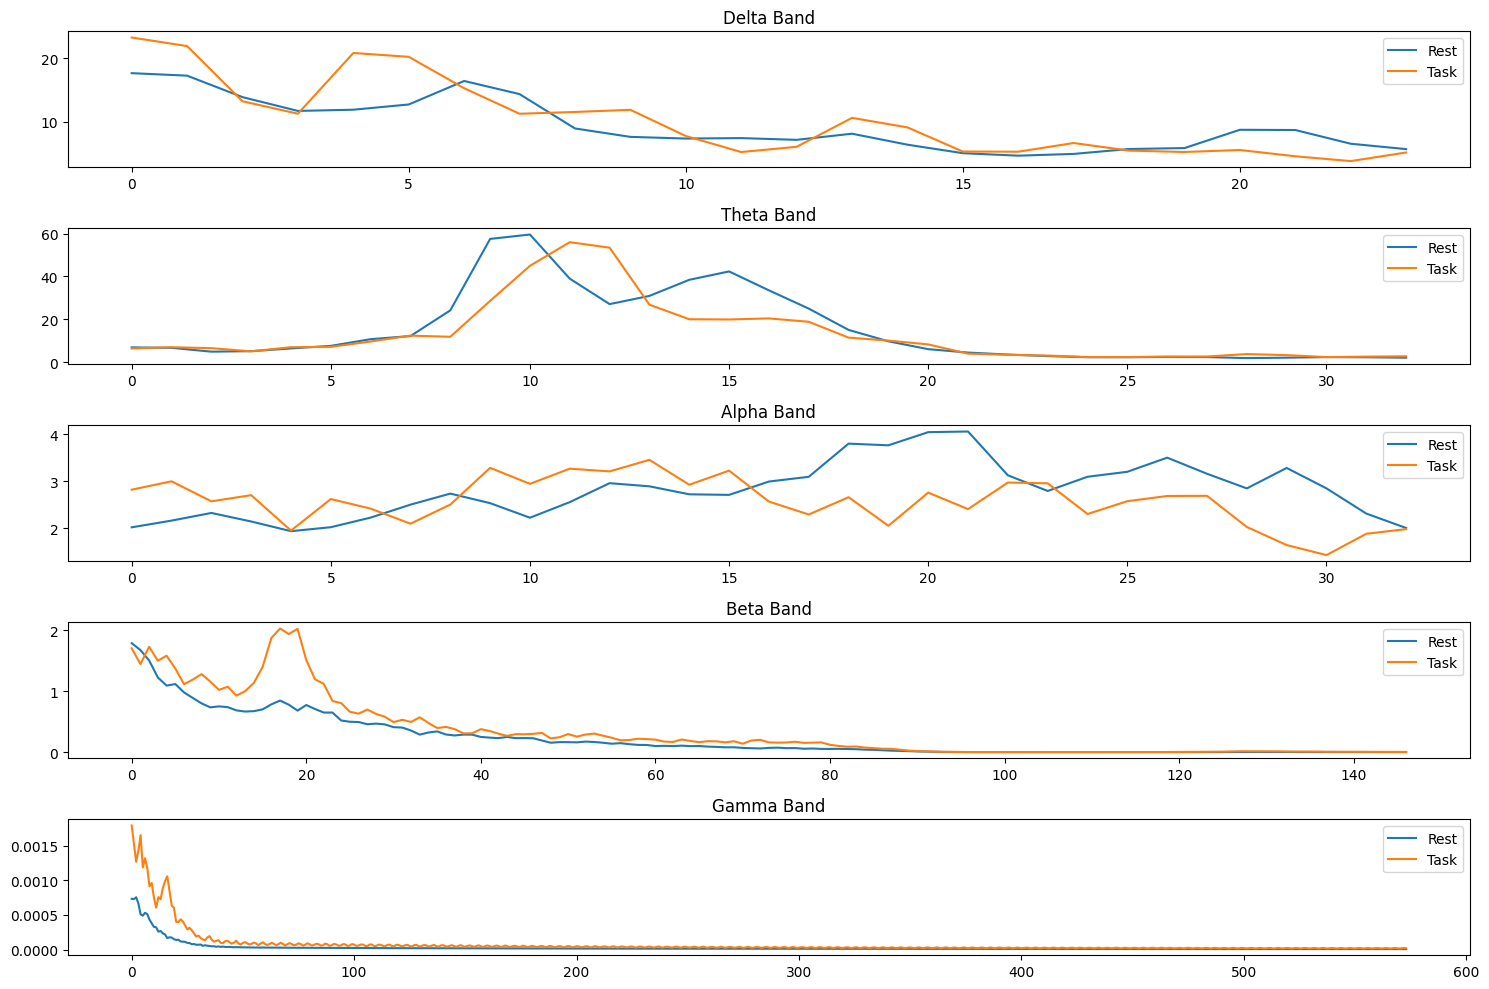

In [11]:
plt.figure(figsize=(15, 10))
for i, (band, psd) in enumerate(psd_rest.items()):
    plt.subplot(len(frequency_bands), 1, i + 1)
    plt.plot(psd.mean(axis=0), label='Rest')
    plt.plot(psd_task[band].mean(axis=0), label='Task')
    plt.title(f'{band} Band')
    plt.legend()
plt.tight_layout()
plt.show()

In [12]:
def extract_features(data, sfreq, frequency_bands):
    features = []
    for band, (fmin, fmax) in frequency_bands.items():
        psd, _ = calculate_psd(data, sfreq, fmin, fmax)
        features.append(psd.mean(axis=1))
    return np.array(features).T

In [13]:
X_rest = []
X_task = []
y = []

In [14]:
for subject_id, info in data.items():
    group = info['group']
    X_rest.append(extract_features(info['rest'], sfreq, frequency_bands))
    X_task.append(extract_features(info['task'], sfreq, frequency_bands))
    y.extend([group] * 2)

Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)
Effective wind

In [15]:
X_rest = np.vstack(X_rest)
X_task = np.vstack(X_task)
y = np.array(y)

In [16]:
X = np.vstack((X_rest, X_task))
y = np.hstack((np.zeros(X_rest.shape[0]), np.ones(X_task.shape[0])))

In [17]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)

In [18]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
LE.fit(y)
y = LE.transform(y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train,  X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [21]:
def create_eegnet():
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [22]:
eegnet = create_eegnet()
history_eegnet = eegnet.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4889 - loss: 0.7102 - val_accuracy: 0.5512 - val_loss: 0.6711
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5511 - loss: 0.6864 - val_accuracy: 0.5545 - val_loss: 0.6662
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5808 - loss: 0.6727 - val_accuracy: 0.5347 - val_loss: 0.6644
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5812 - loss: 0.7136 - val_accuracy: 0.6073 - val_loss: 0.6672
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5887 - loss: 0.6843 - val_accuracy: 0.6007 - val_loss: 0.6666
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5866 - loss: 0.6930 - val_accuracy: 0.6205 - val_loss: 0.6661
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5949 - loss: 0.6759 - val_accuracy: 0.6040 - val_loss: 0.6688
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5909 - loss: 0.6758 - val_accuracy: 0.6172 - v

In [23]:
y_pred = (eegnet.predict(X_test) > 0.5).astype(int)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [24]:
print("EEGNet Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")

EEGNet Metrics:
Accuracy: 0.7029702970297029
Precision: 0.6795580110497238
Recall: 0.7935483870967742
F1-score: 0.7321428571428571


In [25]:
def TSCeption(input_shape, num_classes=2, num_filters=32, kernel_size=5, dropout_rate=0.5):
    inputs = Input(shape=input_shape)

    # Temporal Convolution layers
    conv1 = Conv2D(num_filters, (1, kernel_size), padding='same', activation='relu')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D((1, 4))(conv1)
    
    conv2 = Conv2D(num_filters, (1, kernel_size), padding='same', activation='relu')(inputs)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D((1, 4))(conv2)
    
    conv3 = Conv2D(num_filters, (1, kernel_size), padding='same', activation='relu')(inputs)
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling2D((1, 4))(conv3)

    # Concatenate all temporal layers
    concatenated = concatenate([conv1, conv2, conv3], axis=-1)
    
    flat = Flatten()(concatenated)
    
    # Dense layers
    dense = Dense(128, activation='relu')(flat)
    dense = Dropout(dropout_rate)(dense)
    outputs = Dense(num_classes, activation='softmax')(dense)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [26]:
X_tsc = X.reshape((X.shape[0], 1, 5, 1))

In [27]:
X_train_tsc, X_test_tsc, y_train_tsc, y_test_tsc = train_test_split(X_tsc, y, test_size=0.2, random_state=42)

In [28]:
X_train_tsc,  X_val_tsc, y_train_tsc, y_val_tsc = train_test_split(X_train_tsc, y_train_tsc, test_size=0.25, random_state=1)

In [29]:
num_classes = 2  
tsception_model = TSCeption(input_shape=(1 ,5 ,1), num_classes=2)
tsception_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1, 5, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 1, 5, 32)  │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 1, 5, 32)  │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 1, 5, 32)  │        192 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1, 5, 32)  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 5, 32)  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 5, 32)  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 1, 1, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 1, 1, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 1, 1, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 1, 96)  │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │                   │            │ max_pooling2d_1[… │
│                     │                   │            │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 96)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     12,416 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │        258 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,634 (53.26 KB)

 Trainable params: 13,442 (52.51 KB)

 Non-trainable params: 192 (768.00 B)

In [30]:
history_tsception = tsception_model.fit(X_train_tsc, y_train_tsc, epochs=100, batch_size=16, validation_data=(X_val_tsc, y_val_tsc))

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5280 - loss: 1.1615 - val_accuracy: 0.5743 - val_loss: 0.6755
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5539 - loss: 0.8037 - val_accuracy: 0.5974 - val_loss: 0.6637
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5638 - loss: 0.7289 - val_accuracy: 0.6832 - val_loss: 0.6608
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6068 - loss: 0.6844 - val_accuracy: 0.6304 - val_loss: 0.6651
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6371 - loss: 0.6542 - val_accuracy: 0.6502 - val_loss: 0.6579
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6719 - loss: 0.6168 - val_accuracy: 0.6238 - val_loss: 0.6491
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6783 - loss: 0.6159 - val_accuracy: 0.6799 - val_loss: 0.6204
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6542 - loss: 0.6376 - val_accuracy: 0.5974 - 

In [31]:
y_pred = tsception_model.predict(X_test_tsc)
y_pred_classes = np.argmax(y_pred, axis=1)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [32]:
print("TSCeption Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_classes)}")
print(f"Precision: {precision_score(y_test, y_pred_classes)}")
print(f"Recall: {recall_score(y_test, y_pred_classes)}")
print(f"F1-score: {f1_score(y_test, y_pred_classes)}")

TSCeption Metrics:
Accuracy: 0.7062706270627063
Precision: 0.7088607594936709
Recall: 0.7225806451612903
F1-score: 0.7156549520766773


In [33]:
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEmbedding, self).__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = Dense(units=projection_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=projection_dim)
    
    def call(self, patch):
        batch_size = tf.shape(patch)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions = tf.expand_dims(positions, axis=0)
        positions = tf.tile(positions, [batch_size, 1])
        
        projected_patches = self.projection(patch)
        position_embeddings = self.position_embedding(positions)
        
        if projected_patches.shape[1] != position_embeddings.shape[1]:
            position_embeddings = tf.tile(tf.expand_dims(position_embeddings, axis=1), 
                                          [1, tf.shape(projected_patches)[1], 1])
        
        embedded_patches = projected_patches + position_embeddings
        return embedded_patches

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_patches, self.projection_dim)

In [34]:
def create_vit_classifier(input_shape, num_classes, transformer_layers, num_heads, patch_size, projection_dim, dropout_rate):
    inputs = Input(shape=input_shape)
    
    # Determine the number of patches and patch dimension
    if input_shape[0] == 1 and input_shape[1] == 1:
        num_patches = 1
        patch_dim = input_shape[2]
    else:
        # For larger inputs, we could divide into patches here
        num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
        patch_dim = patch_size * patch_size * input_shape[2]
    
    # Reshape the input into patches 
    patches = Reshape((num_patches, patch_dim))(inputs)
    
    # Create patch embeddings
    patch_embeddings = PatchEmbedding(num_patches=num_patches, projection_dim=projection_dim)(patches)
    
    # Create Transformer blocks
    for _ in range(transformer_layers):
        x1 = LayerNormalization(epsilon=1e-6)(patch_embeddings)
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(x1, x1)
        x2 = Dropout(dropout_rate)(attention_output)
        x3 = x2 + patch_embeddings
        
        x4 = LayerNormalization(epsilon=1e-6)(x3)
        
        # MLP block
        mlp_hidden_units = [projection_dim * 4, projection_dim * 2, projection_dim]
        for units in mlp_hidden_units:
            x4 = Dense(units, activation=tf.nn.gelu)(x4)
            x4 = Dropout(dropout_rate)(x4)
        
        patch_embeddings = x4 + x3
    
    representation = LayerNormalization(epsilon=1e-6)(patch_embeddings)
    representation = Flatten()(representation)
    representation = Dropout(dropout_rate)(representation)
    
    outputs = Dense(num_classes, activation='softmax')(representation)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [35]:
X_vit = X.reshape((X.shape[0], 1, 1, 5))

In [36]:
X_train_vit, X_test_vit, y_train_vit, y_test_vit = train_test_split(X_vit, y, test_size=0.2, random_state=42)

In [37]:
X_train_vit,  X_val_vit, y_train_vit, y_val_vit = train_test_split(X_train_vit, y_train_vit, test_size=0.25, random_state=1)

In [38]:
input_shape = (1, 1, 5)  
num_classes = 2  
transformer_layers = 8
num_heads = 4
patch_size = 4
projection_dim = 64
dropout_rate = 0.1

In [39]:
vit_classifier = create_vit_classifier(input_shape, num_classes, transformer_layers, num_heads, patch_size, projection_dim, dropout_rate)
vit_classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
vit_classifier.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1, 1, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 5)      │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 1, 64)     │        448 │ reshape[0][0]     │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 64)     │        128 │ patch_embedding[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 64)     │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1, 64)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 64)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ patch_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1, 256)    │     16,640 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1, 256)    │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1, 128)    │     32,896 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 1, 128)    │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1, 64)     │      8,256 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 1, 64)     │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 64)     │          0 │ dropout_7[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1, 64)     │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 1, 64)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1, 64)     │          0 │ dropout_9[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add_2[0][0]     

 Total params: 996,034 (3.80 MB)

 Trainable params: 996,034 (3.80 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
y_train_vit_onehot = tf.keras.utils.to_categorical(y_train_vit, num_classes=2)
y_val_vit_onehot = tf.keras.utils.to_categorical(y_val_vit, num_classes=2)
y_test_vit_onehot = tf.keras.utils.to_categorical(y_test_vit, num_classes=2)

In [41]:
history_vit = vit_classifier.fit(X_train_vit, y_train_vit_onehot, epochs=100, batch_size=16, validation_data=(X_val_vit, y_val_vit_onehot))

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 126ms/step - accuracy: 0.5465 - loss: 0.9803 - val_accuracy: 0.5182 - val_loss: 0.7188
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5816 - loss: 0.7222 - val_accuracy: 0.6106 - val_loss: 0.6613
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.6020 - loss: 0.6541 - val_accuracy: 0.5776 - val_loss: 0.6822
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.5664 - loss: 0.7180 - val_accuracy: 0.6040 - val_loss: 0.6417
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.6189 - loss: 0.6599 - val_accuracy: 0.6502 - val_loss: 0.6291
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5749 - loss: 0.6891 - val_accuracy: 0.5941 - val_loss: 0.6529
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.5804 - loss: 0.6836 - val_accuracy: 0.5479 - val_loss: 0.6684
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.6050 - loss: 0.6649 - val_accuracy: 

In [42]:
y_pred = vit_classifier.predict(X_test_vit)
y_pred_classes = np.argmax(y_pred, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 360ms/step


In [43]:
print("ViT Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_classes)}")
print(f"Precision: {precision_score(y_test, y_pred_classes)}")
print(f"Recall: {recall_score(y_test, y_pred_classes)}")
print(f"F1-score: {f1_score(y_test, y_pred_classes)}")

ViT Metrics:
Accuracy: 0.7029702970297029
Precision: 0.7443609022556391
Recall: 0.6387096774193548
F1-score: 0.6875


In [44]:
class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        self.filters = filters
    
    def build(self, input_shape):
        self.avg_pool = GlobalAveragePooling2D()
        self.reshape = Reshape((1, 1, self.filters))
        self.dense1 = Dense(self.filters // 8, activation='relu')
        self.dense2 = Dense(self.filters, activation='sigmoid')
        super(AttentionBlock, self).build(input_shape)
    
    def call(self, inputs):
        avg_pool = self.avg_pool(inputs)
        avg_pool = self.reshape(avg_pool)
        avg_pool = self.dense1(avg_pool)
        avg_pool = self.dense2(avg_pool)
        return Multiply()([inputs, avg_pool])
    
    def compute_output_shape(self, input_shape):
        return input_shape
    
    def get_config(self):
        config = super(AttentionBlock, self).get_config()
        config.update({'filters': self.filters})
        return config

In [45]:
def attention_block(inputs, filters):
    avg_pool = GlobalAveragePooling2D()(inputs)
    avg_pool = Reshape((1, 1, filters))(avg_pool)
    avg_pool = Dense(filters // 8, activation='relu')(avg_pool)
    avg_pool = Dense(filters, activation='sigmoid')(avg_pool)
    
    return Multiply()([inputs, avg_pool])

def ATCNet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Temporal Convolution layers with attention
    conv1 = Conv2D(32, (1, 5), padding='same', activation='relu')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = MaxPooling2D((1, 1))(conv1)
    conv1 = attention_block(conv1, 32)
    
    conv2 = Conv2D(64, (1, 5), padding='same', activation='relu')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = MaxPooling2D((1, 1))(conv2)
    conv2 = attention_block(conv2, 64)

    conv3 = Conv2D(128, (1, 5), padding='same', activation='relu')(conv2)
    conv3 = BatchNormalization()(conv3)
    conv3 = MaxPooling2D((1, 1))(conv3)
    conv3 = attention_block(conv3, 128)

    flat = GlobalAveragePooling2D()(conv3)
    
    dense = Dense(64, activation='relu')(flat)
    dense = Dropout(0.5)(dense)
    outputs = Dense(num_classes, activation='softmax')(dense)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [46]:
X_atc = X.reshape((X.shape[0], 1, 1, 5))

In [47]:
X_train_atc, X_test_atc, y_train_atc, y_test_atc = train_test_split(X_atc, y, test_size=0.2, random_state=42)

In [48]:
X_train_atc,  X_val_atc, y_train_atc, y_val_atc = train_test_split(X_train_atc, y_train_atc, test_size=0.25, random_state=1)

In [49]:
input_shape = (1, 1, 5)
num_classes = 2  
atcnet_model = ATCNet(input_shape, num_classes)
atcnet_model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1, 1, 5)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 1, 1, 32)  │        832 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 32)  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 1, 1, 32)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ max_pooling2d_3[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 32)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1, 1, 4)   │        132 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1, 1, 32)  │        160 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 32)  │          0 │ max_pooling2d_3[… │
│                     │                   │            │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 1, 1, 64)  │     10,304 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 1, 1, 64)  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ max_pooling2d_4[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 1, 1, 8)   │        520 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 1, 1, 64)  │        576 │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1, 1, 64)  │          0 │ max_pooling2d_4[… │
│ (Multiply)          │                   │            │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 1, 1, 128) │     41,088 │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 1, 128) │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 1, 1, 128) │          0 │ batch_normalizat

 Total params: 67,134 (262.24 KB)

 Trainable params: 66,686 (260.49 KB)

 Non-trainable params: 448 (1.75 KB)

In [50]:
y_train_atc_onehot = tf.keras.utils.to_categorical(y_train_atc, num_classes=2)
y_val_atc_onehot = tf.keras.utils.to_categorical(y_val_atc, num_classes=2)
y_test_atc_onehot = tf.keras.utils.to_categorical(y_test_atc, num_classes=2)

In [51]:
history_atcnet = atcnet_model.fit(X_train_atc, y_train_atc_onehot, epochs=100, batch_size=16, validation_data=(X_val_atc, y_val_atc_onehot))

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5553 - loss: 0.7713 - val_accuracy: 0.4851 - val_loss: 0.6933
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5740 - loss: 0.7126 - val_accuracy: 0.4884 - val_loss: 0.6927
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5911 - loss: 0.6723 - val_accuracy: 0.5083 - val_loss: 0.6914
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6107 - loss: 0.6538 - val_accuracy: 0.5248 - val_loss: 0.6897
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6111 - loss: 0.6485 - val_accuracy: 0.5710 - val_loss: 0.6848
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6754 - loss: 0.6062 - val_accuracy: 0.6238 - val_loss: 0.6759
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6611 - loss: 0.6294 - val_accuracy: 0.6568 - val_loss: 0.6563
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6364 - loss: 0.6052 - val_accuracy: 0.6205 

In [52]:
y_pred = atcnet_model.predict(X_test_atc)
y_pred_classes = np.argmax(y_pred, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [53]:
print("ATCNet Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_classes)}")
print(f"Precision: {precision_score(y_test, y_pred_classes)}")
print(f"Recall: {recall_score(y_test, y_pred_classes)}")
print(f"F1-score: {f1_score(y_test, y_pred_classes)}")

ATCNet Metrics:
Accuracy: 0.6963696369636964
Precision: 0.6909090909090909
Recall: 0.7354838709677419
F1-score: 0.7125


In [54]:
latent_dim = 16

# Encoder
def build_encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    return Model(inputs, [z_mean, z_log_var], name='encoder')

# Sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Decoder
def build_decoder(input_shape):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(128, activation='relu')(latent_inputs)
    x = Dense(np.prod(input_shape), activation='relu')(x)
    x = Reshape(input_shape)(x)
    x = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    outputs = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
    return Model(latent_inputs, outputs, name='decoder')

In [55]:
# VAE
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var = self.encoder(inputs)
        z = sampling([z_mean, z_log_var])
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(kl_loss))
        return reconstructed

# Loss function
def vae_loss(inputs, outputs):
    reconstruction_loss = tf.keras.losses.MeanSquaredError()(K.flatten(inputs), K.flatten(outputs))
    return reconstruction_loss


In [56]:
X_vae = X.reshape((X.shape[0], 1, 1, 5))

In [57]:
X_train_vae, X_test_vae, y_train_vae, y_test_vae = train_test_split(X_vae, y, test_size=0.2, random_state=42)

In [58]:
X_train_vae,  X_val_vae, y_train_vae, y_val_vae = train_test_split(X_train_vae, y_train_vae, test_size=0.25, random_state=1)

In [59]:
input_shape = (1, 1, 5)
encoder = build_encoder(input_shape)
decoder = build_decoder(input_shape)
vae = VAE(encoder, decoder)
vae.compile(optimizer=Adam())
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ?                      │       427,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ ?                      │       404,102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 832,038 (3.17 MB)

 Trainable params: 830,118 (3.17 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [60]:
history_vae = vae.fit(X_train_vae, X_train_vae, epochs=100, batch_size=16, validation_data=(X_val_vae, X_val_vae))

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 1.3072e-05 - val_loss: 1.2000e-08
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.6274e-09 - val_loss: 1.0229e-08
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0236e-08 - val_loss: 1.0819e-09
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.3708e-09 - val_loss: 2.9507e-10
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.6433e-09 - val_loss: 1.8688e-09
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6.5315e-09 - val_loss: 3.9343e-10
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 3.1409e-09 - val_loss: 5.9014e-09
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.3753e-08 - val_loss: 5.3211e-08
Epoch 9/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.5521e-08 - val_loss: 1.4114e-07
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.2227e-08 - val_loss: 2.8622e-08
Epoch 11/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - los

In [61]:
encoder = Model(encoder.input, encoder.get_layer('z_mean').output)
X_train_encoded = encoder.predict(X_train_vae)
X_test_encoded = encoder.predict(X_test_vae)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [62]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train_encoded, y_train)

LogisticRegression()

In [63]:
y_pred = clf.predict(X_test_encoded)

In [64]:
print("VAE + Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1-score: {f1_score(y_test, y_pred)}")

VAE + Logistic Regression Metrics:
Accuracy: 0.5115511551155115
Precision: 0.5115511551155115
Recall: 1.0
F1-score: 0.6768558951965066


In [65]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    accuracy = accuracy_score(y_test, y_pred_classes)
    precision = precision_score(y_test, y_pred_classes, average='macro')
    recall = recall_score(y_test, y_pred_classes, average='macro')
    f1 = f1_score(y_test, y_pred_classes, average='macro')
    return accuracy, precision, recall, f1

In [66]:
acc_eegnet, prec_eegnet, rec_eegnet, f1_eegnet = evaluate_model(eegnet, X_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [67]:
acc_tsception, prec_tsception, rec_tsception, f1_tsception = evaluate_model(tsception_model, X_test_tsc, y_test_tsc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [68]:
acc_vit, prec_vit, rec_vit, f1_vit = evaluate_model(vit_classifier, X_test_vit, y_test_vit)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [69]:
acc_atcnet, prec_atcnet, rec_atcnet, f1_atcnet = evaluate_model(atcnet_model, X_test_atc, y_test_atc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [70]:
X_test_encoded = encoder.predict(X_test_vae)
y_pred_vae = clf.predict(X_test_encoded)
acc_vae = accuracy_score(y_test, y_pred_vae)
prec_vae = precision_score(y_test, y_pred_vae, average='macro')
rec_vae = recall_score(y_test, y_pred_vae, average='macro')
f1_vae = f1_score(y_test, y_pred_vae, average='macro')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


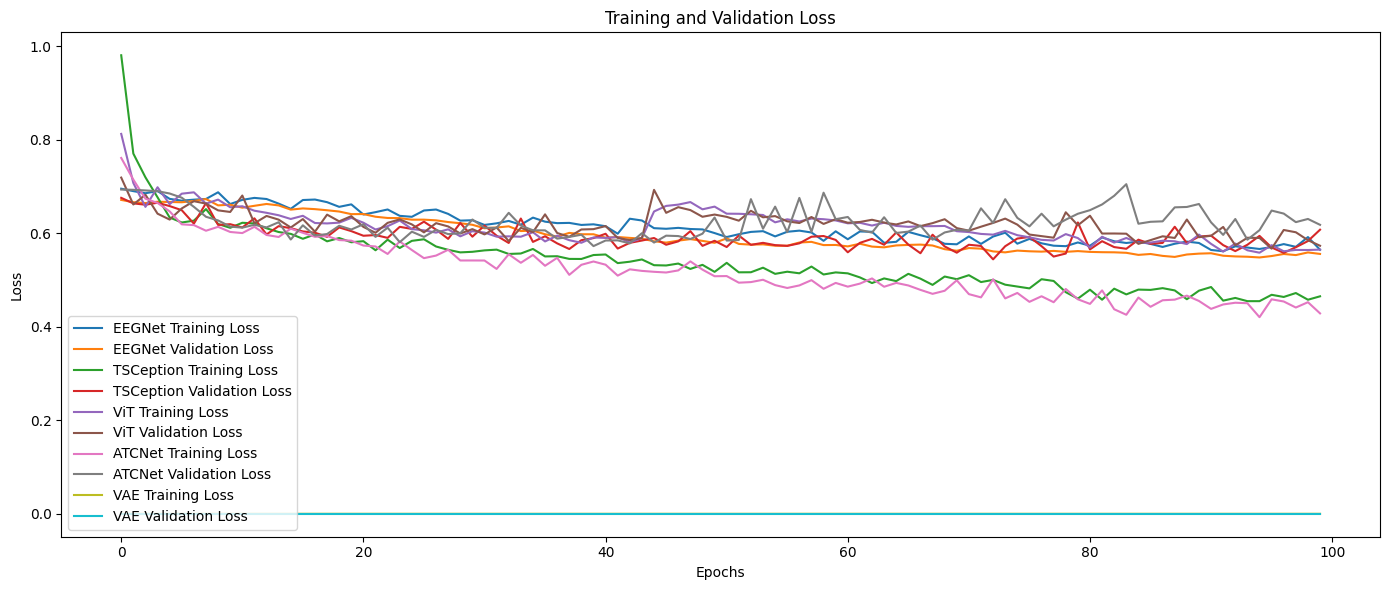

In [71]:
plt.figure(figsize=(14, 6))

plt.plot(history_eegnet.history['loss'], label='EEGNet Training Loss')
plt.plot(history_eegnet.history['val_loss'], label='EEGNet Validation Loss')
plt.plot(history_tsception.history['loss'], label='TSCeption Training Loss')
plt.plot(history_tsception.history['val_loss'], label='TSCeption Validation Loss')
plt.plot(history_vit.history['loss'], label='ViT Training Loss')
plt.plot(history_vit.history['val_loss'], label='ViT Validation Loss')
plt.plot(history_atcnet.history['loss'], label='ATCNet Training Loss')
plt.plot(history_atcnet.history['val_loss'], label='ATCNet Validation Loss')
plt.plot(history_vae.history['loss'], label='VAE Training Loss')
plt.plot(history_vae.history['val_loss'], label='VAE Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

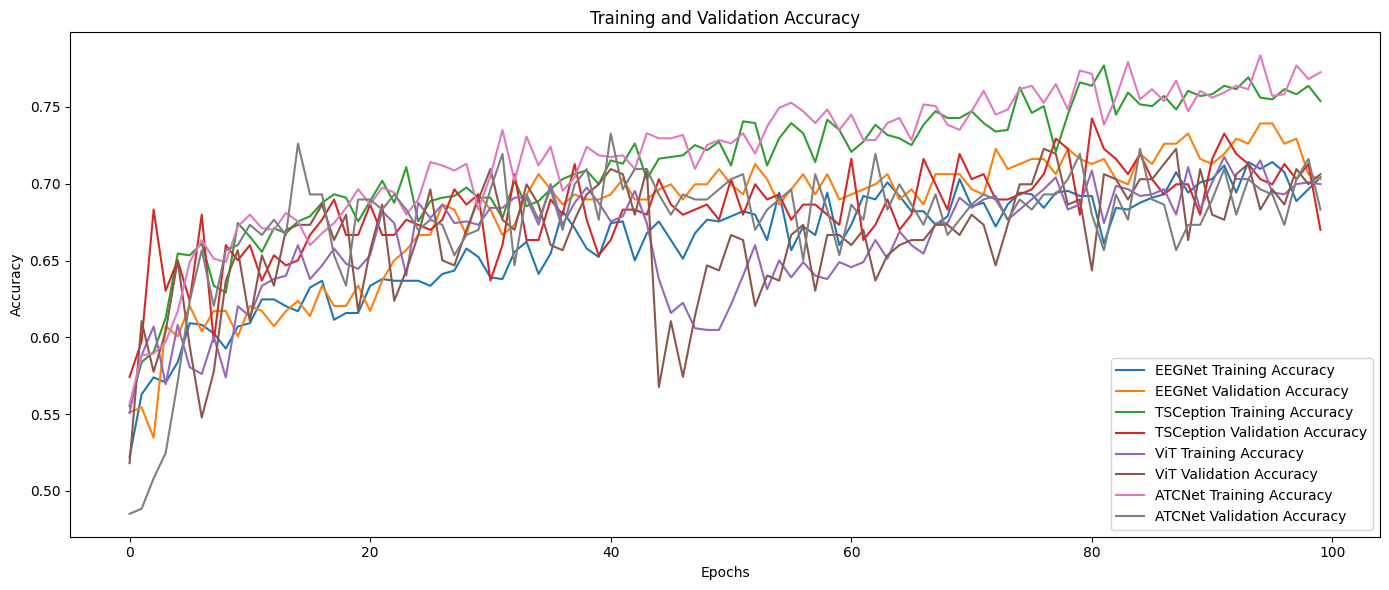

In [72]:
# Plot training and validation accuracy curves
plt.figure(figsize=(14, 6))

plt.plot(history_eegnet.history['accuracy'], label='EEGNet Training Accuracy')
plt.plot(history_eegnet.history['val_accuracy'], label='EEGNet Validation Accuracy')
plt.plot(history_tsception.history['accuracy'], label='TSCeption Training Accuracy')
plt.plot(history_tsception.history['val_accuracy'], label='TSCeption Validation Accuracy')
plt.plot(history_vit.history['accuracy'], label='ViT Training Accuracy')
plt.plot(history_vit.history['val_accuracy'], label='ViT Validation Accuracy')
plt.plot(history_atcnet.history['accuracy'], label='ATCNet Training Accuracy')
plt.plot(history_atcnet.history['val_accuracy'], label='ATCNet Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

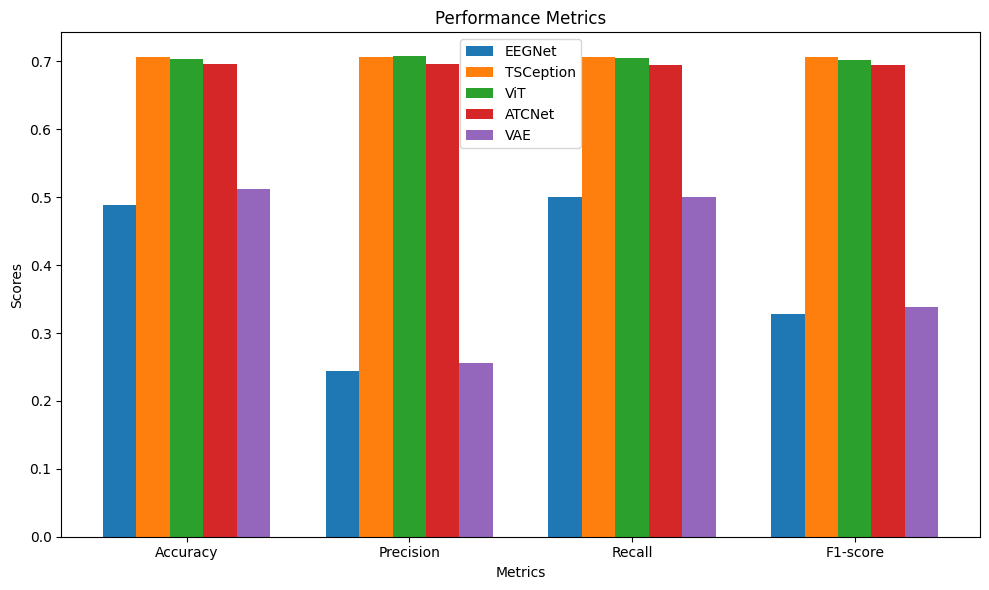

In [73]:
# Plot performance metrics in a bar chart
plt.figure(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(metrics))
width = 0.15

eegnet_metrics = [acc_eegnet, prec_eegnet, rec_eegnet, f1_eegnet]
tsception_metrics = [acc_tsception, prec_tsception, rec_tsception, f1_tsception]
vit_metrics = [acc_vit, prec_vit, rec_vit, f1_vit]
atcnet_metrics = [acc_atcnet, prec_atcnet, rec_atcnet, f1_atcnet]
vae_metrics = [acc_vae, prec_vae, rec_vae, f1_vae]

plt.bar(x - 2*width, eegnet_metrics, width, label='EEGNet')
plt.bar(x - width, tsception_metrics, width, label='TSCeption')
plt.bar(x, vit_metrics, width, label='ViT')
plt.bar(x + width, atcnet_metrics, width, label='ATCNet')
plt.bar(x + 2*width, vae_metrics, width, label='VAE')

plt.title('Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks(x, metrics)
plt.legend()
plt.tight_layout()
plt.show()

# <centre> TSCeption, VIT, ATCNet are choosed for Further Improvements </centre>